<a href="https://colab.research.google.com/github/xqyn/gamlss/blob/main/repli_GAMLSS_Rruntime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Replica of  [Dinga et.al](https://www.biorxiv.org/content/10.1101/2021.06.14.448106v1)

In [34]:
install.packages('gamlss.dist', dependencies = TRUE)
install.packages('reshape2', dependencies = TRUE)
install.packages('cowplot', dependencies = TRUE)
install.packages('viridis', dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘textshaping’, ‘Cairo’, ‘magick’, ‘ragg’


Warning message in install.packages("cowplot", dependencies = TRUE):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages("cowplot", dependencies = TRUE):
“installation of package ‘Cairo’ had non-zero exit status”
Warning message in install.packages("cowplot", dependencies = TRUE):
“installation of package ‘magick’ had non-zero exit status”
Warning message in install.packages("cowplot", dependencies = TRUE):
“installation of package ‘ragg’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [35]:
library(gamlss.dist)
library(mgcv)
library(reshape2)
library(ggplot2)
library(cowplot)
library(patchwork)
library(viridis)

In [36]:
.libPaths()

[1] "/usr/local/lib/R/site-library" "/usr/lib/R/site-library"      
[3] "/usr/lib/R/library"

In [37]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] viridis_0.6.2     viridisLite_0.4.0 patchwork_1.1.1   cowplot_1.1.1    
 [5] ggplot2_3.3.5     reshape2_1.4.4    mgcv_1.8-39       nlme_3.1-155     
 [9] gamlss.dist_6.0-3 MASS_7.3-55      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-7     tidyselec

In [38]:
n <- 1000
x <- seq(0, 100, length.out = n)
sigmas <- 0.5 + 1.5*seq(from = -1, to = 1, length.out = n)**2
y  <- 50 + 0.15*x - 0.003*(x**2) + rSHASHo2(n = n, sigma = sigmas,   nu=-1.5, tau=1)

df1 <- data.frame('x' = x, 'y' = y, 'dataset'='Training site')

In [40]:
m1 <- gam(list(y ~ x, # basically the same model as lm(y~x, data=df1)
                   ~ 1), 
            family=gaulss(),
            data=df1)

m2 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ 1), # fit sigma only as an intercept
            family=gaulss(),
            data=df1)

m3 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x)), # fit sigma as a smooth function of x
            family=gaulss(),
            data=df1)

m4 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x), # fit sigma as a smooth function of x
                   ~ 1, # fit nu (skewness) as an intercept
                   ~ 1), # fit tau (kurtosis) as an intercept
            family=shash(), # shash distribution instead of gaussian 
            data=df1)

In [41]:
predictions_params_m1 <- predict(m1, newdata = df1)
predictions_params_m2 <- predict(m2, newdata = df1)
predictions_params_m3 <- predict(m3, newdata = df1)
predictions_params_m4 <- predict(m4, newdata = df1)

In [42]:
params_to_quantiles_norm <- function(quantiles, params){
  as.data.frame(sapply(quantiles, 
      function(q){
        qnorm(p=q, mean=params[,1], sd = exp(params[,2]))
      }))
}


params_to_quantiles_shash <- function(quantiles, params, qshash){
  as.data.frame(sapply(quantiles, 
      function(q){
        qshash(p=q, 
               # param is called mu, but it expects 
               # a vector of all 4 shash parameters
               mu=params)
      }))
}



quantiles <- pnorm(c(-2:2))
qshash <- m4$family$qf

predictions_quantiles_m1 <- params_to_quantiles_norm(quantiles, 
                                                     predictions_params_m1)
predictions_quantiles_m2 <- params_to_quantiles_norm(quantiles,
                                                     predictions_params_m2)
predictions_quantiles_m3 <- params_to_quantiles_norm(quantiles, 
                                                     predictions_params_m3)
predictions_quantiles_m4 <- params_to_quantiles_shash(quantiles, 
                                                      predictions_params_m4,
                                                      qshash)

reshape_quantiles_to_long <- function(quantiles_df, x_var){
  quantiles_df$x <- x_var
  return(reshape2::melt(quantiles_df, id.vars = c('x')))
}

predictions_quantiles_m1_long <- reshape_quantiles_to_long(predictions_quantiles_m1, df1$x)
predictions_quantiles_m2_long <- reshape_quantiles_to_long(predictions_quantiles_m2, df1$x)
predictions_quantiles_m3_long <- reshape_quantiles_to_long(predictions_quantiles_m3, df1$x)
predictions_quantiles_m4_long <- reshape_quantiles_to_long(predictions_quantiles_m4, df1$x)

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 77 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 46 row(s) containing missing values (geom_path).”


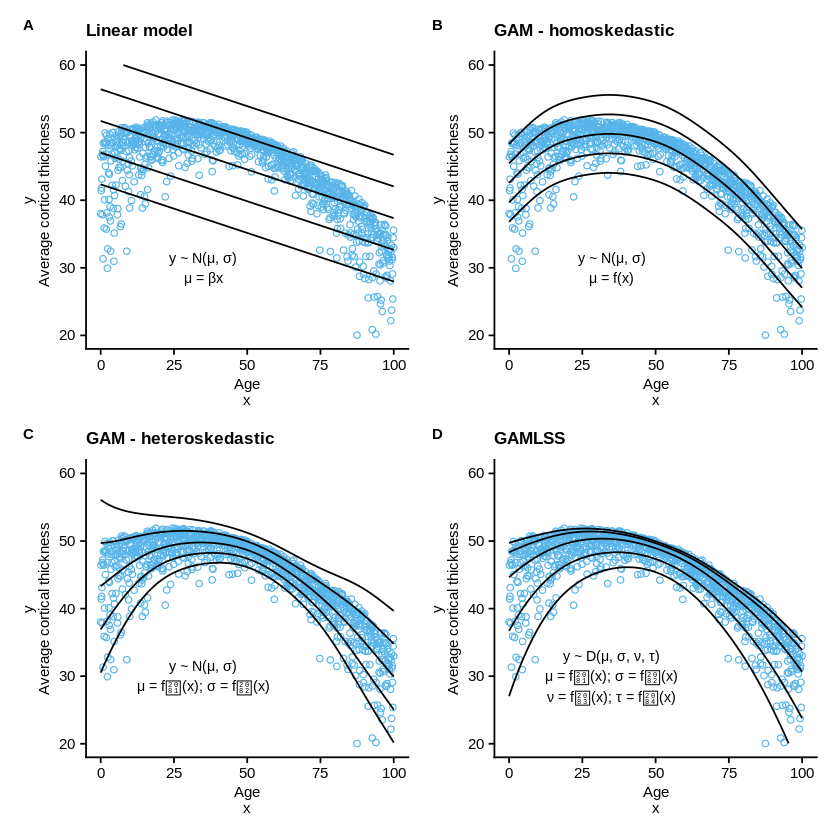

In [44]:
p1 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m1_long, aes(x=x, y=value, group=variable)) +
  labs(title='Linear model',
       # subtitle='Mean of y is modeled as a linear function of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = βx") +
  ylim(c(20,60));

p2 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m2_long, aes(x=x, y=value, group=variable)) +
  labs(title='GAM - homoskedastic',
       # subtitle='Mean of y is modeled as a smooth function of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = f(x)") +
  ylim(c(20,60))

p3 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m3_long, aes(x=x, y=value, group=variable)) +
  labs(title='GAM - heteroskedastic',
       # subtitle='Mean and variance of y are modeled\nas smooth funcitons of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = f₁(x); σ = f₂(x)") +
  ylim(c(20,60))

p4 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m4_long, 
            aes(x=x, y=value, group=variable)) +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  + 
  annotate("text", x = 35, y = 30, size=3,
           label = "y ~ D(μ, σ, ν, τ)\nμ = f₁(x); σ = f₂(x)\nν = f₃(x); τ = f₄(x)") +
  ylim(c(20,60))+
  theme_minimal(); 


p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=9),
                  axis.text = element_text(size=9)); p_all

# ggsave('fig_lm_to_gamls.png',
#        p_all, width = 5, height = 5, units = 'in')

In [45]:
k <- 100
x<-df1$x
y<-df1$y

contour_cols <- viridis(k, alpha = 0.5)
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

dens <- get_density(x, y, k)

[1] "#44015480" "#45055880" "#46085C80" "#470D6080" "#47106380" "#48146780"
  [7] "#48176980" "#481B6D80" "#481E7080" "#48217380" "#48257680" "#48287880"
 [13] "#472C7A80" "#472F7C80" "#46327E80" "#45358180" "#45388280" "#443B8480"
 [19] "#433E8580" "#42418680" "#40458780" "#3F478880" "#3E4A8980" "#3D4D8A80"
 [25] "#3C508B80" "#3B528B80" "#39558C80" "#38598C80" "#375B8D80" "#355E8D80"
 [31] "#34608D80" "#33638D80" "#32658E80" "#31688E80" "#2F6B8E80" "#2E6D8E80"
 [37] "#2D708E80" "#2C718E80" "#2B748E80" "#2A768E80" "#29798E80" "#287C8E80"
 [43] "#277E8E80" "#26818E80" "#26828E80" "#25858E80" "#24878E80" "#238A8D80"
 [49] "#228D8D80" "#218F8D80" "#20928C80" "#20938C80" "#1F968B80" "#1F998A80"
 [55] "#1E9B8A80" "#1F9E8980" "#1FA08880" "#1FA28780" "#20A48680" "#22A78580"
 [61] "#24AA8380" "#25AC8280" "#28AE8080" "#2BB07F80" "#2EB37C80" "#31B67B80"
 [67] "#35B77980" "#39BA7680" "#3DBC7480" "#41BE7180" "#47C06F80" "#4CC26C80"
 [73] "#51C56A80" "#56C66780" "#5BC86380" "#61CA6080" "#67CC5C80" "#6DCD5980"
 [79] "#73D05680" "#78D15280" "#7FD34E80" "#85D54A80" "#8CD64680" "#92D74180"
 [85] "#99D83D80" "#A0DA3980" "#A7DB3580" "#ADDC3080" "#B4DE2C80" "#BBDE2880"
 [91] "#C2DF2380" "#C9E02080" "#D0E11C80" "#D7E21980" "#DDE31880" "#E4E41980"
 [97] "#EBE51A80" "#F1E51D80" "#F7E62080" "#FDE72580"

Warning message:
“Duplicated aesthetics after name standardisation: shape”
Warning message:
“Ignoring unknown parameters: xlab, ylab”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 46 row(s) containing missing values (geom_path).”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


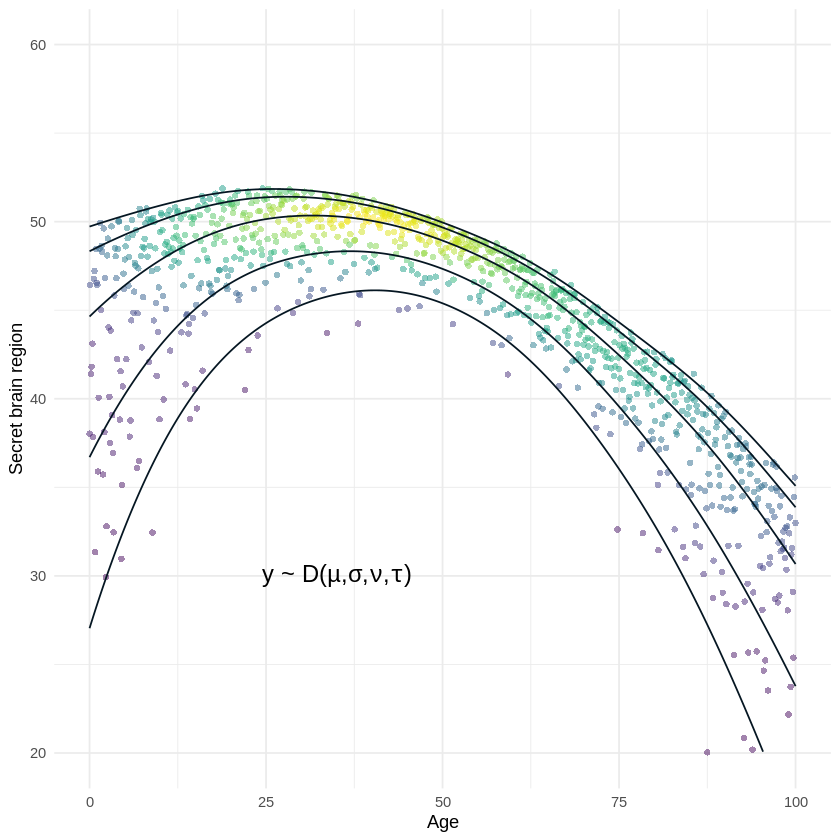

In [46]:
## 2. Generating plots -----
def.par<-par()

contour_cols

ggplot(df1) +
  geom_point(aes(x=x, y=y), 
             col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], pch = 16, xlab="", ylab="",
             shape=21) +
  geom_line(data=predictions_quantiles_m4_long, 
            aes(x=x, y=value, group=variable),
            color='#051622') +
  labs(#title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age', 
       y='Secret brain region')  + 
  annotate("text", x = 35, y = 30, size=5,
           label = expression(paste(
             'y ~ D(',mu,',',sigma,',',nu,',',tau,')',
             )))+
           ylim(c(20,60))+
  theme_minimal()

